# Analyse exploratoire des donn√©es des 1000 meilleurs films selon IMDB 

Nous allons analyser puis class√© les sentiments des avis sur les films 

plan :

1. Analyse exploratoire des donn√©es 
2. Analyse des sentiments
3. classification des sentiments (Machine Learning & Deep learning )


In [1]:
# library 
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from pathlib import Path
sns.set_theme(style="whitegrid", palette="pastel")
from matplotlib import rcParams

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



## Importation des donn√©es

In [2]:
BASE_DIR = Path().resolve().parent
DATA_DIR = BASE_DIR / 'Data' 

#print(f"BASE_DIR: {BASE_DIR}")
#print(f"DATA_DIR: {DATA_DIR}")

# import des donn√©es 
df = pd.read_csv(DATA_DIR / 'Top_1000_IMDb_movies.csv')
df.head(3)

Unnamed: 0                Movie Name Year of Release  Watch Time  \
0           0  The Shawshank Redemption            1994         142   
1           1             The Godfather            1972         175   
2           2           The Dark Knight            2008         152   

   Movie Rating  Metascore of movie   Gross      Votes  \
0           9.3                82.0   28.34  27,77,378   
1           9.2               100.0  134.97  19,33,588   
2           9.0                84.0  534.86  27,54,087   

                                         Description  
0  Over the course of several years, two convicts...  
1  Don Vito Corleone, head of a mafia family, dec...  
2  When the menace known as the Joker wreaks havo...

In [3]:
print(f"la database contient {df.shape[0]} lignes et {df.shape[1]} colonnes")
print(f"les colonnes sont : {df.columns.tolist()}")

la database contient 1000 lignes et 9 colonnes
les colonnes sont : ['Unnamed: 0', 'Movie Name', 'Year of Release', 'Watch Time', 'Movie Rating', 'Metascore of movie', 'Gross', 'Votes', 'Description']


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1000 non-null   int64  
 1   Movie Name          1000 non-null   object 
 2   Year of Release     1000 non-null   object 
 3   Watch Time          1000 non-null   int64  
 4   Movie Rating        1000 non-null   float64
 5   Metascore of movie  845 non-null    float64
 6   Gross               838 non-null    object 
 7   Votes               1000 non-null   object 
 8   Description         1000 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 70.4+ KB


- Taille : 1000 lignes, 9 colonnes

- Colonnes avec valeurs manquantes :

    Metascore of movie : 845/1000 non-null

    Gross : 838/1000 non-null

    Types √† corriger :

Year of Release, Gross, et Votes sont des object, ce qui est probablement incorrect si tu veux faire des analyses num√©riques ou temporelles.

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.describe() 

unnamed:_0   watch_time  movie_rating  metascore_of_movie
count  1000.000000  1000.000000   1000.000000          845.000000
mean    499.500000   124.253000      7.970200           79.011834
std     288.819436    28.800355      0.275732           11.973800
min       0.000000    45.000000      7.600000           28.000000
25%     249.750000   103.000000      7.800000           71.000000
50%     499.500000   120.000000      7.900000           80.000000
75%     749.250000   139.000000      8.100000           88.000000
max     999.000000   321.000000      9.300000          100.000000

`watch_time` (dur√©e du film) :
- Moyenne : 124 min ‚Üí des films classiques en termes de dur√©e.
- Minimum : 45 min ‚Üí peut-√™tre un documentaire ou un court-m√©trage.
- Maximum : 321 min ‚Üí √ßa c‚Äôest long ! Peut-√™tre un film tr√®s sp√©cial ou un probl√®me de donn√©e √† v√©rifier.

`movie_rating` (note du film) :
- Notes √©lev√©es en g√©n√©ral (entre 7.6 et 9.3), ce qui sugg√®re une base de donn√©es avec des films bien not√©s.
-√âcart-type faible (0.27) ‚Üí les notes sont assez regroup√©es, peu de variation.

`metascore_of_movie` :
- Moyenne : 79 sur 100 ‚Üí plut√¥t bon.
- Valeurs manquantes : 155 films (~15%) n‚Äôont pas de Metascore ‚Üí √† g√©rer.

### **Analyses**

In [6]:
# suppression de la colonne inutile 'Unnamed: 0'

df = df.drop('unnamed:_0', axis=1)

#### **movie rating (Note du film)**

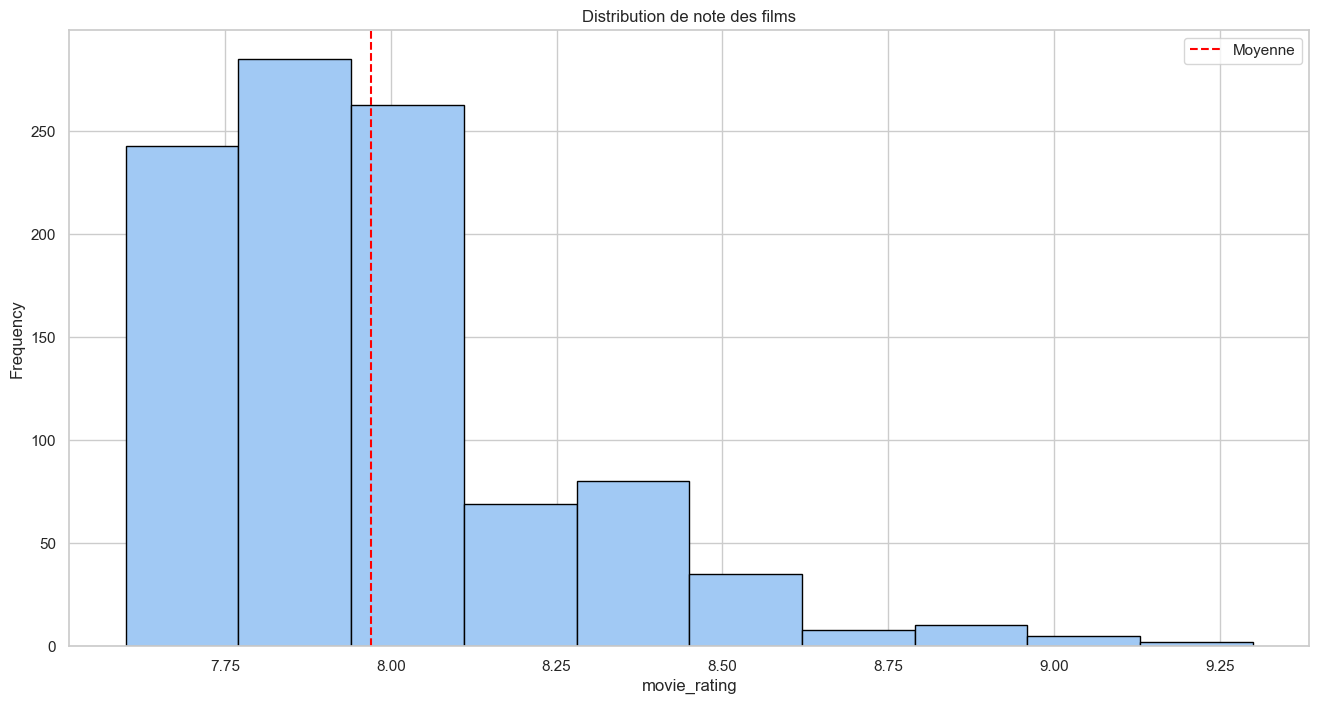

In [7]:
plt.figure(figsize=(16,8))
plt.hist(df['movie_rating'], bins=10, edgecolor='black')
plt.axvline(df['movie_rating'].mean(), color='red', linestyle='--', label='Moyenne')
plt.legend()
plt.xlabel('movie_rating')
plt.ylabel('Frequency')
plt.title('Distribution de note des films')
plt.show()

La majorit√© des films ont une note entre 7.75 et 8.1.

La distribution est asym√©trique √† droite : peu de films au-dessus de 8.5.

#### **Diagramme de dispersion des √©valuations de films par rapport √† la valeur brute**

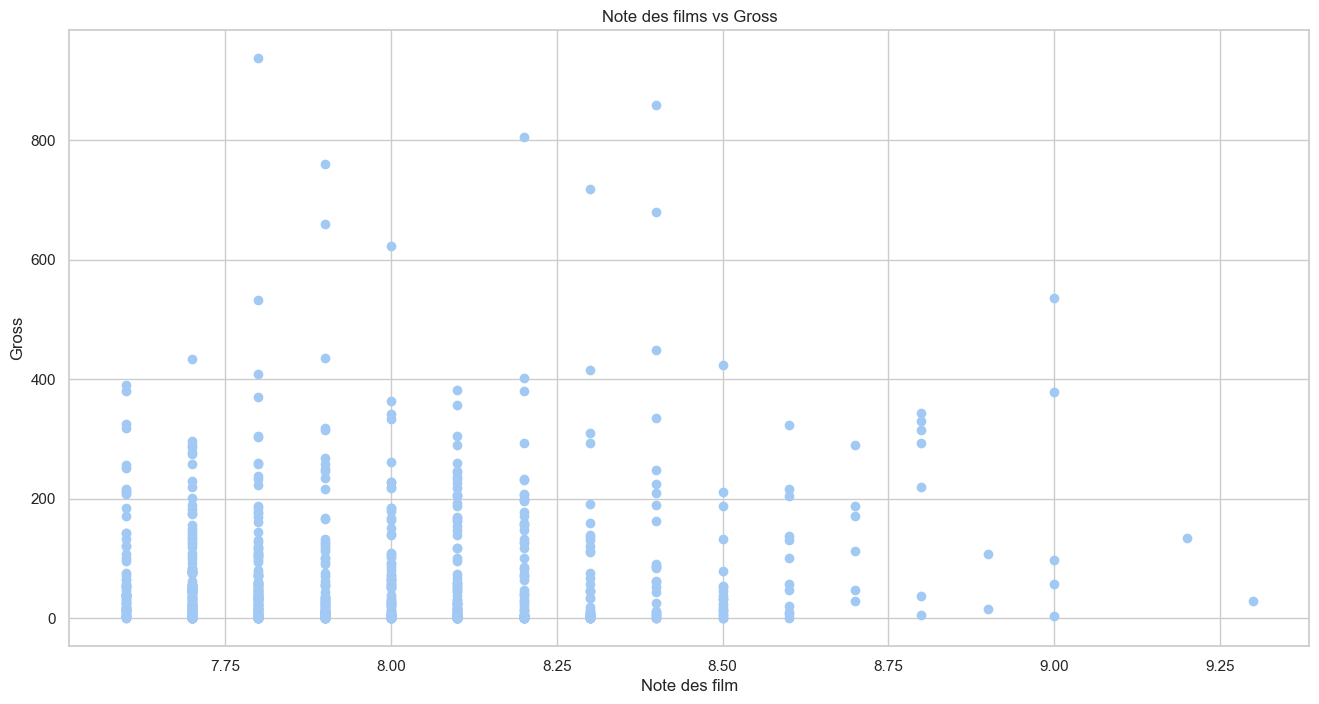

In [8]:
df['gross'] = pd.to_numeric(df['gross'].str.replace(',', ''), errors='coerce')

plt.figure(figsize=(16,8))
plt.scatter(df['movie_rating'], df['gross'])
plt.xlabel('Note des film')
plt.ylabel('Gross')
plt.title('Note des films vs Gross')
plt.show()

Pas de vraie corr√©lation visuelle forte entre la note et le box-office (Gross).

Des films tr√®s bien not√©s (> 8.5) peuvent avoir un faible revenu, et inversement.

Certains films autour de 8.0‚Äì8.3 ont g√©n√©r√© beaucoup de revenus (> 800), ce qui est int√©ressant.

#### **Films sortis par intervalles de 5 ans**

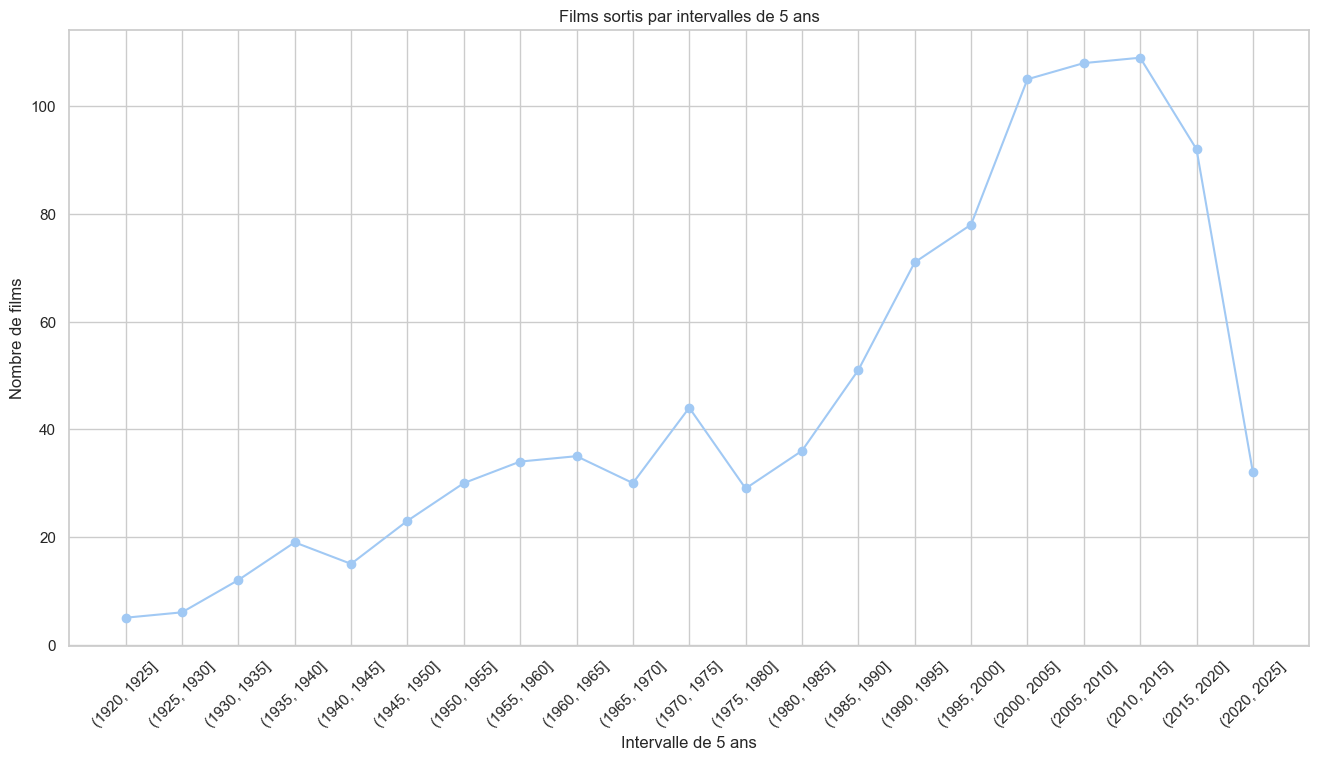

In [9]:
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce')

# Create a new column for 5-year intervals
df['year_interval'] = pd.cut(df['year_of_release'], bins=range(int(df['year_of_release'].min()), int(df['year_of_release'].max()) + 6, 5))

# Comptez le nombre de films sortis dans chaque intervalle. 
interval_movie_count = df.groupby('year_interval')['movie_name'].count()

# Convertir les √©tiquettes des intervalles en cha√Ænes de caract√®res 
interval_movie_count.index = interval_movie_count.index.astype(str)

# Cr√©er un graphique lin√©aire pour le nombre de films sur des intervalles de 5 ans 

plt.figure(figsize=(16,8))
plt.plot(interval_movie_count.index, interval_movie_count.values, marker='o')
plt.xlabel('Intervalle de 5 ans')
plt.ylabel('Nombre de films')
plt.title('Films sortis par intervalles de 5 ans')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**Tendance historique**:
- Une croissance lente jusqu'aux ann√©es 1970‚Äì1980.
- Puis une acc√©l√©ration continue jusque 2010‚Äì2015, avec un pic autour de 2005‚Äì2015 (~105 films sur 5 ans).
- Ensuite, une chute nette entre 2015‚Äì2025, probablement li√©e √† :

Un effet de bord du dataset (il est possible que les films les plus r√©cents n‚Äôaient pas encore assez de recul pour √™tre class√©s haut)

Ou bien √† la p√©riode COVID impactant la production/distribution.

#### **Distribution des √©valuations de films par intervalles de 5 ans**

C:\Users\NAZIFOU\AppData\Local\Temp\ipykernel_2720\133623191.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=df['year_interval'].unique())


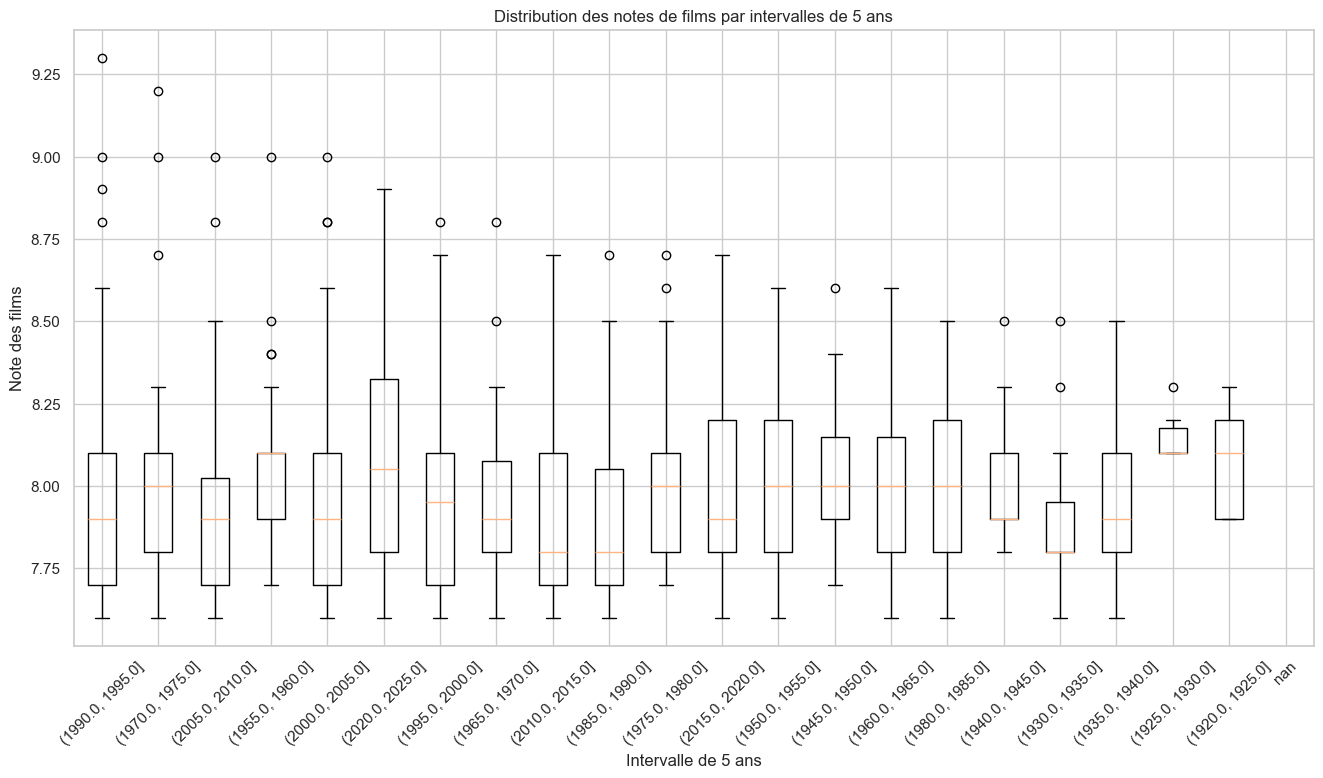

In [10]:
df = df.dropna(subset=['year_of_release'])

# Convertir l'ann√©e de publication en valeur num√©rique pour les calculs
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce')

# Cr√©er une nouvelle colonne pour les intervalles de 5 ans
df['year_interval'] = pd.cut(df['year_of_release'], bins=range(int(df['year_of_release'].min()), int(df['year_of_release'].max()) + 6, 5))

# Cr√©er une figure et des axes
plt.figure(figsize=(16, 8))

# Liste pour stocker les donn√©es du diagramme en bo√Æte pour chaque intervalle
boxplot_data = []

# Boucle sur chaque intervalle de 5 ans
for interval in df['year_interval'].unique():
    interval_data = df[df['year_interval'] == interval]['movie_rating']
    boxplot_data.append(interval_data)
    
# Graphique 

plt.boxplot(boxplot_data, labels=df['year_interval'].unique())

plt.xlabel('Intervalle de 5 ans')
plt.ylabel('Note des films')
plt.title('Distribution des notes de films par intervalles de 5 ans')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Notes globalement stables** :
- La m√©diane des notes tourne autour de 7.9 √† 8.1 sur presque tous les intervalles.
- Aucune p√©riode ne ressort de mani√®re extraordinairement haute ou basse.

**Quelques pics int√©ressants** :
- 1930‚Äì1950 semble contenir des films tr√®s bien not√©s (plusieurs outliers > 9).
- 1990‚Äì1995 et 2000‚Äì2005 ont une bonne m√©diane et quelques films tr√®s bien not√©s.

Un l√©ger fl√©chissement r√©cent ?
- Les intervalles 2010‚Äì2020 affichent une m√©diane un tout petit peu plus basse.

√Ä croiser avec ton observation pr√©c√©dente : le Metascore baisse aussi dans les ann√©es r√©centes.



#### **Distribution de la dur√©e de visionnage des films**

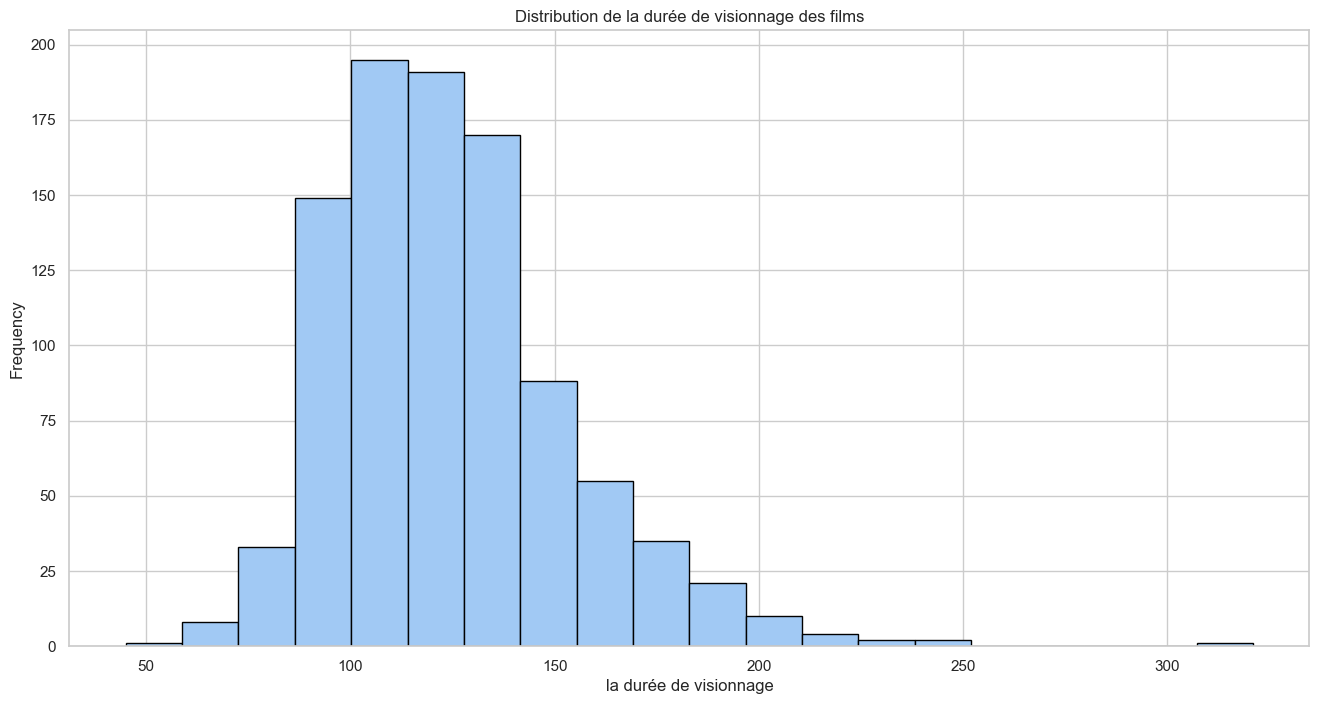

In [11]:
plt.figure(figsize=(16, 8))
plt.hist(df['watch_time'], bins=20, edgecolor='black')
plt.xlabel('la dur√©e de visionnage')
plt.ylabel('Frequency')
plt.title('Distribution de la dur√©e de visionnage des films')
plt.show()

on observe :

    - Distribution en forme de cloche l√©g√®rement asym√©trique, centr√©e autour de 100‚Äì130 minutes.
    - La majorit√© des films durent entre 90 et 150 minutes, ce qui est tr√®s classique.
    -Tr√®s peu de films tr√®s courts (< 60 min) ou tr√®s longs (> 180 min).

Il y a quelques valeurs extr√™mes (outliers) vers 250+ min, √† garder en t√™te pour une √©ventuelle normalisation ou nettoyage plus tard.

#### **√âvaluation agr√©g√©e vs Metascore**

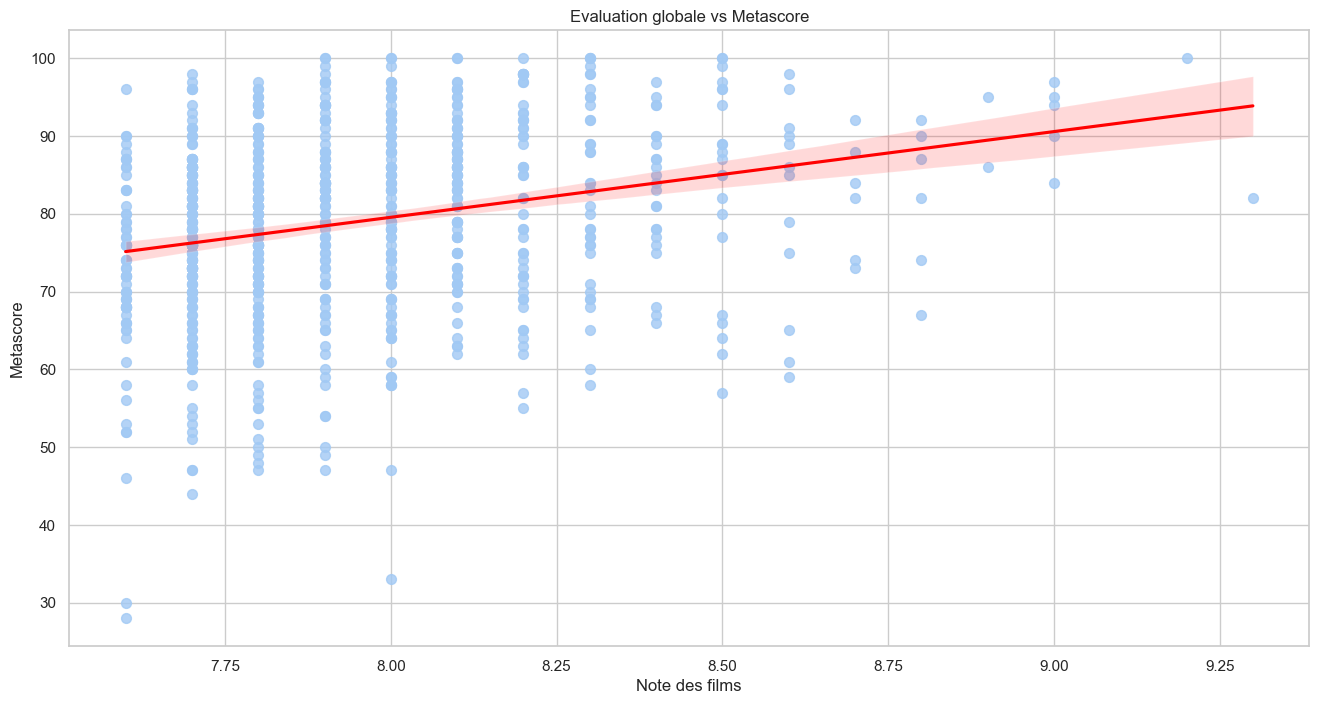

In [ ]:
df = df.dropna(subset=['metascore_of_movie'])

# Graphique de la distribution de la note Metascore
plt.figure(figsize=(16, 8))
sns.regplot(x='movie_rating', y='metascore_of_movie', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.xlabel('Note des films')
plt.ylabel('Metascore')
plt.title('Evaluation globale vs Metascore')
plt.grid(True)
plt.show()

Corr√©lation positive visible (et confirm√©e par la droite rouge de r√©gression).

Plus un film est bien not√© par le public, plus il a de chances d‚Äôavoir un bon Metascore (critique presse).

Mais : il y a tout de m√™me de la dispersion ‚Üí certains films tr√®s bien not√©s n‚Äôont pas un Metascore √©lev√©, et inversement.

#### **Distribution des √©valuations de films**

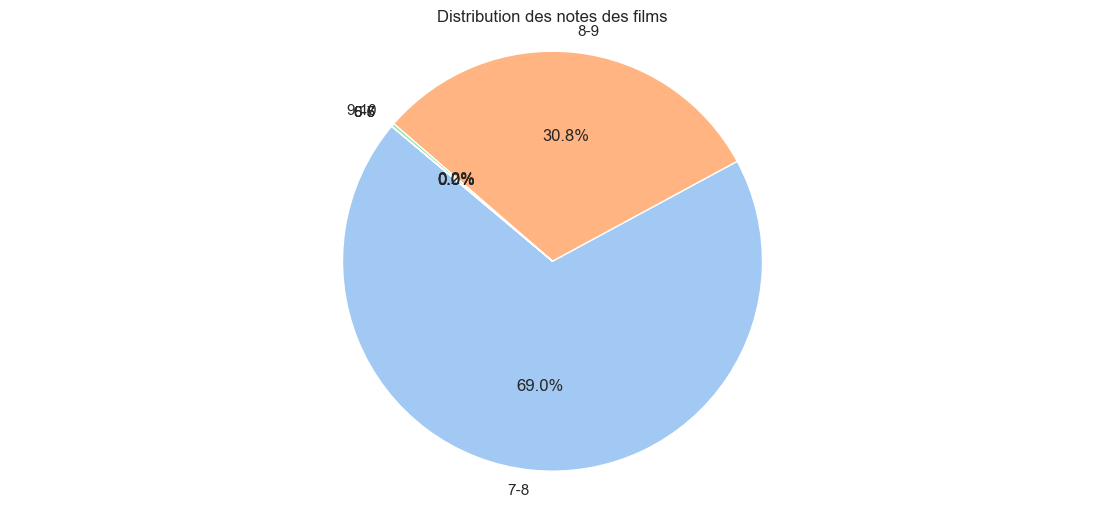

In [14]:
plt.figure(figsize=(14, 6))
rating_bins = [0, 5, 6, 7, 8, 9, 10]
rating_labels = ['0-5', '5-6', '6-7', '7-8', '8-9', '9-10']
rating_distribution = pd.cut(df['movie_rating'], bins=rating_bins, labels=rating_labels)
plt.pie(rating_distribution.value_counts(), labels=rating_distribution.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des notes des films')
plt.axis('equal')
plt.show()

- 69% des films ont une note entre 7 et 8 ‚Üí donc majorit√© des films "bons", sans √™tre excellents.
- 30.8% ont une note entre 8 et 9 ‚Üí les tr√®s bons films.
- Les films not√©s en dessous de 7 ou au-dessus de 9 sont quasi absents

#### **Nombre cumul√© de films au fil des ans**

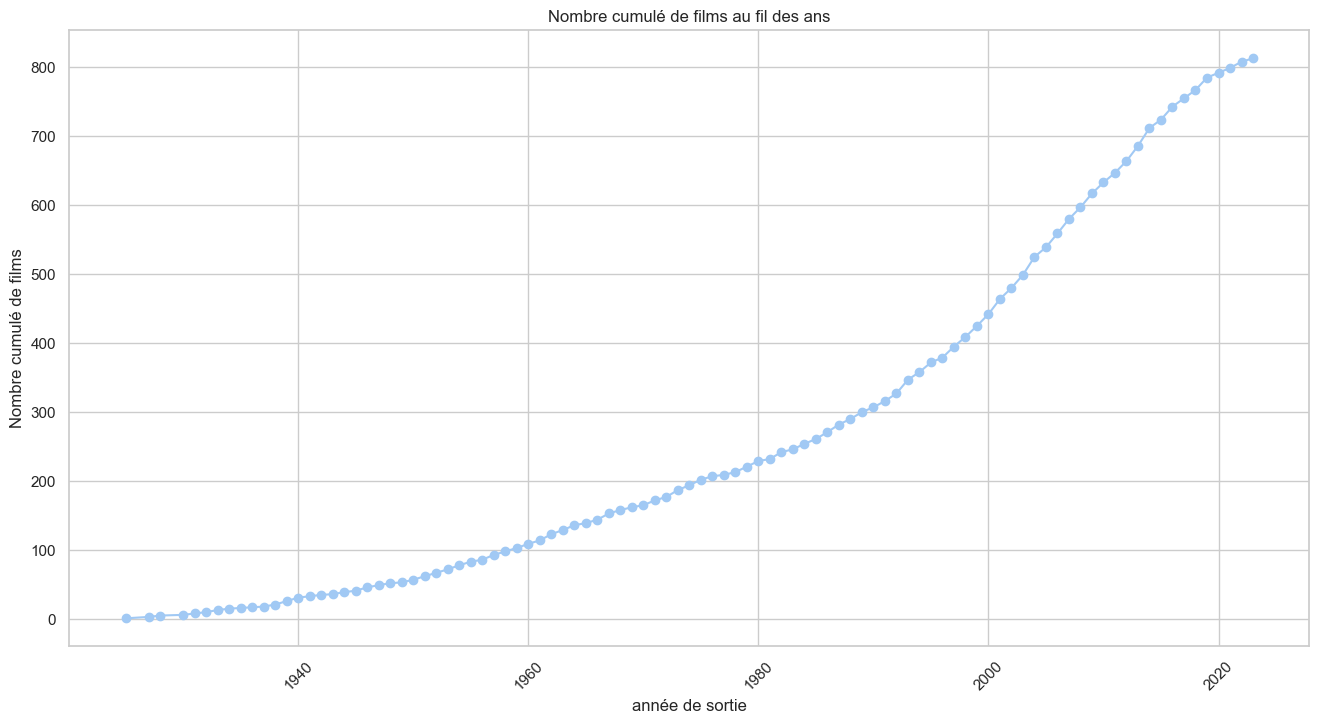

In [15]:
year_count = df['year_of_release'].value_counts().sort_index().cumsum()
plt.figure(figsize=(16, 8)) 
plt.plot(year_count.index, year_count.values, marker='o')
plt.xlabel('ann√©e de sortie') 
plt.ylabel('Nombre cumul√© de films')
plt.title('Nombre cumul√© de films au fil des ans')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

On voit une acc√©l√©ration nette √† partir des ann√©es 2000, avec une croissance bien plus rapide du nombre de films.

Jusqu'aux ann√©es 80‚Äì90, la croissance est plus lin√©aire.

Vers 2020, la courbe ralentit un peu ‚Üí peut-√™tre √† cause de la pand√©mie ou du dataset limit√© aux meilleures notes ?

#### **√©valuation des films en fonction de la dur√©e de visionnage**

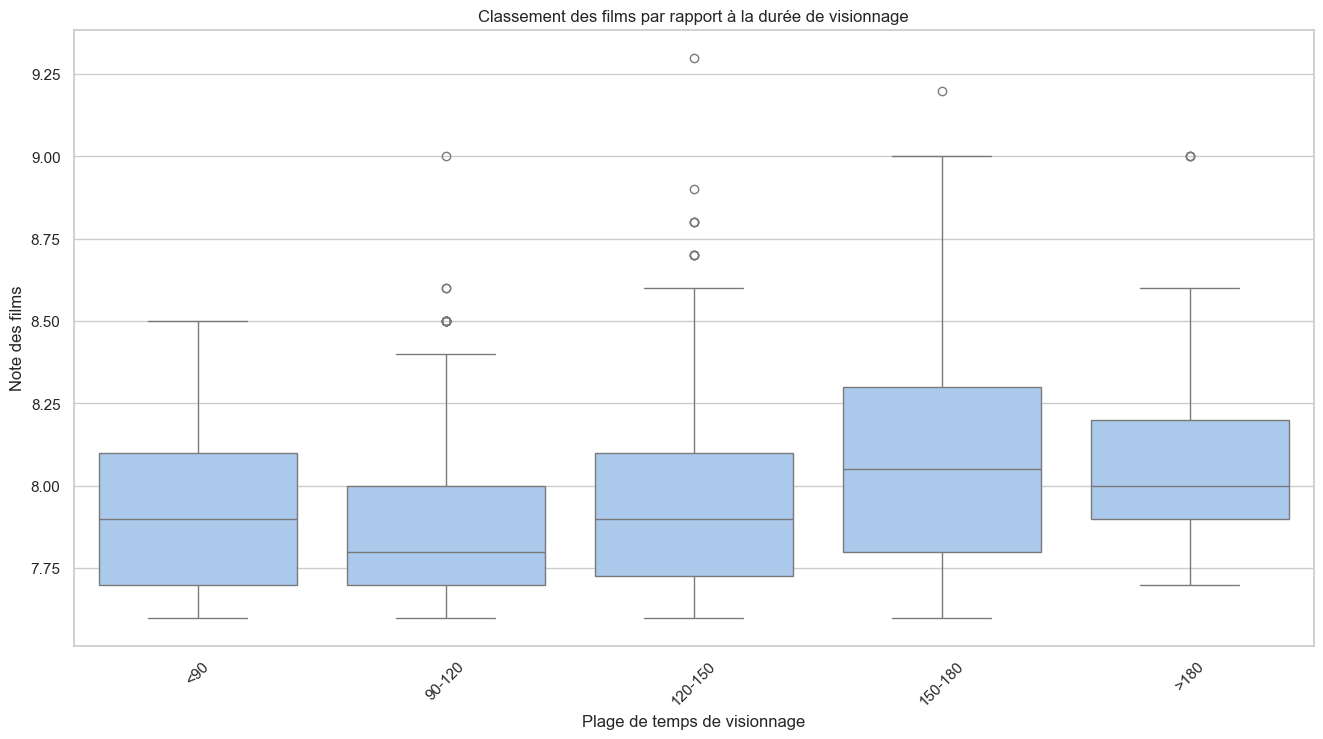

In [16]:
watch_time_bins = [0, 90, 120, 150, 180, float('inf')]
watch_time_labels = ['<90', '90-120', '120-150', '150-180', '>180']
df['watch_time_range'] = pd.cut(df['watch_time'], bins=watch_time_bins, labels=watch_time_labels)
plt.figure(figsize=(16, 8))
sns.boxplot(x='watch_time_range', y='movie_rating', data=df)
plt.xlabel('Plage de temps de visionnage')
plt.ylabel('Note des films') 
plt.title('Classement des films par rapport √† la dur√©e de visionnage')
plt.xticks(rotation=45)
plt.show()

- Les films entre 150‚Äì180 minutes ont la m√©diane de note la plus haute, avec plusieurs outliers tr√®s bien not√©s.
- Les films courts (<90 min) et ceux entre 90‚Äì120 min ont des notes un peu plus basses en moyenne.
- Les films tr√®s longs (>180) ne se d√©marquent pas tant que √ßa, mais ont un score m√©dian quand m√™me au-dessus de 8.

Les films plus longs ont tendance √† √™tre mieux not√©s, mais pas forc√©ment de mani√®re extr√™me. Peut-√™tre parce qu‚Äôils prennent plus de temps pour d√©velopper l‚Äôhistoire, ou qu‚Äôils sont souvent plus "ambitieux" ?

#### **Relations √† variables multiples**

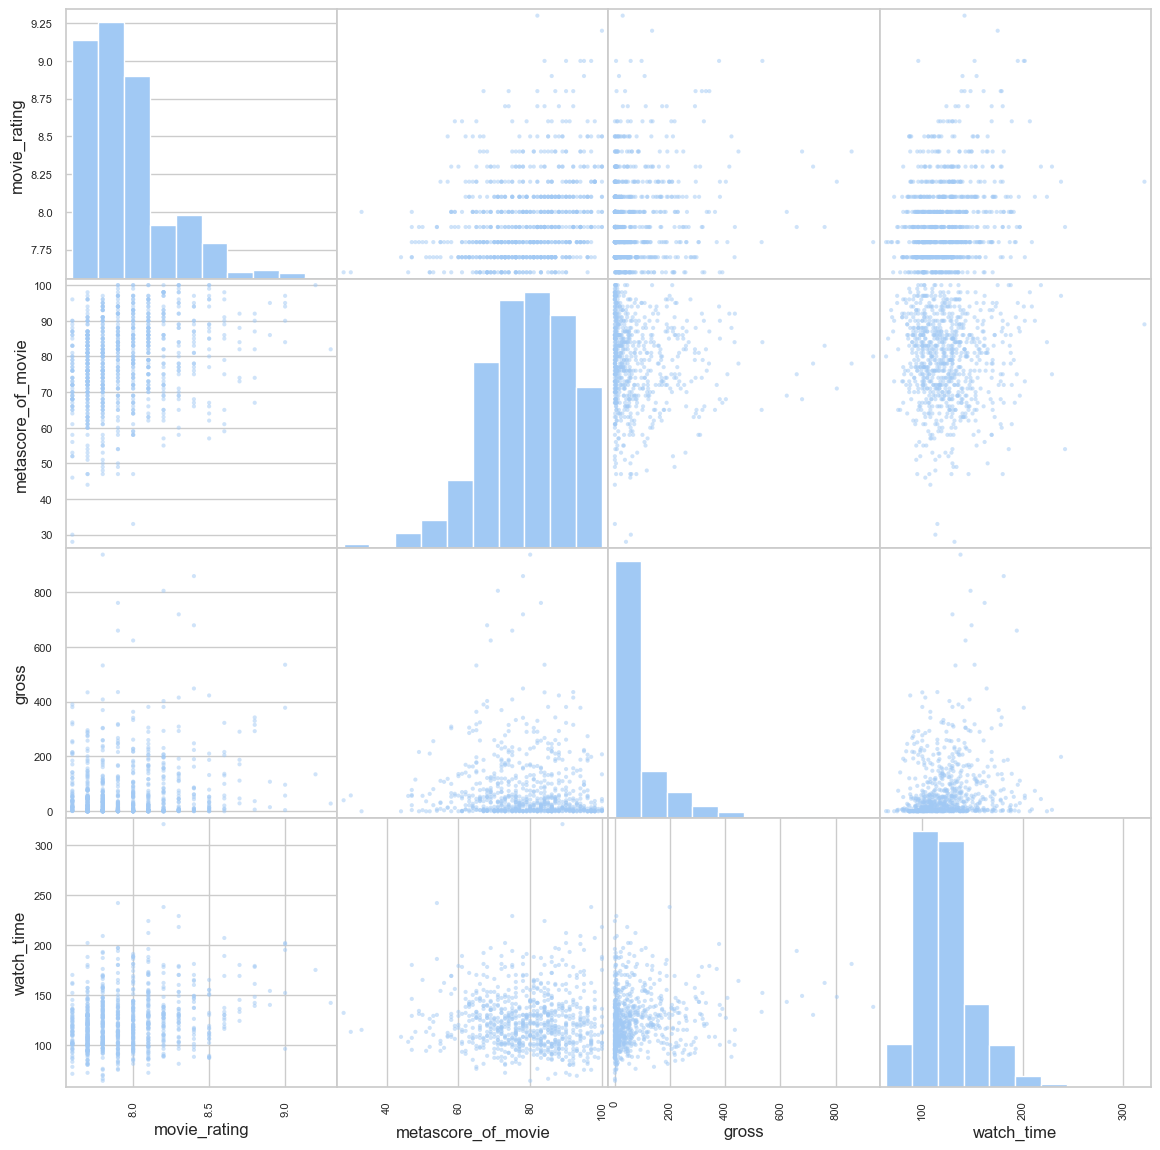

In [17]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[['movie_rating', 'metascore_of_movie', 'gross', 'watch_time']], figsize=(14, 14))
plt.show()

**movie_rating vs metascore_of_movie**
Corr√©lation visible, positive (confirm√©e visuellement comme dans ton graphe pr√©c√©dent).

**gross vs tout le reste** :
Aucune relation claire avec les autres variables ‚Üí tr√®s dispers√©.

Peut √™tre influenc√© par des facteurs non pr√©sents ici (marketing, distribution, acteur, etc.).

**watch_time** :
Pas de lien flagrant avec la note ni le revenu.

Mais un petit nuage concentr√© entre 90 et 150 minutes ‚Üí dur√©e standard.


#### **Correlation**

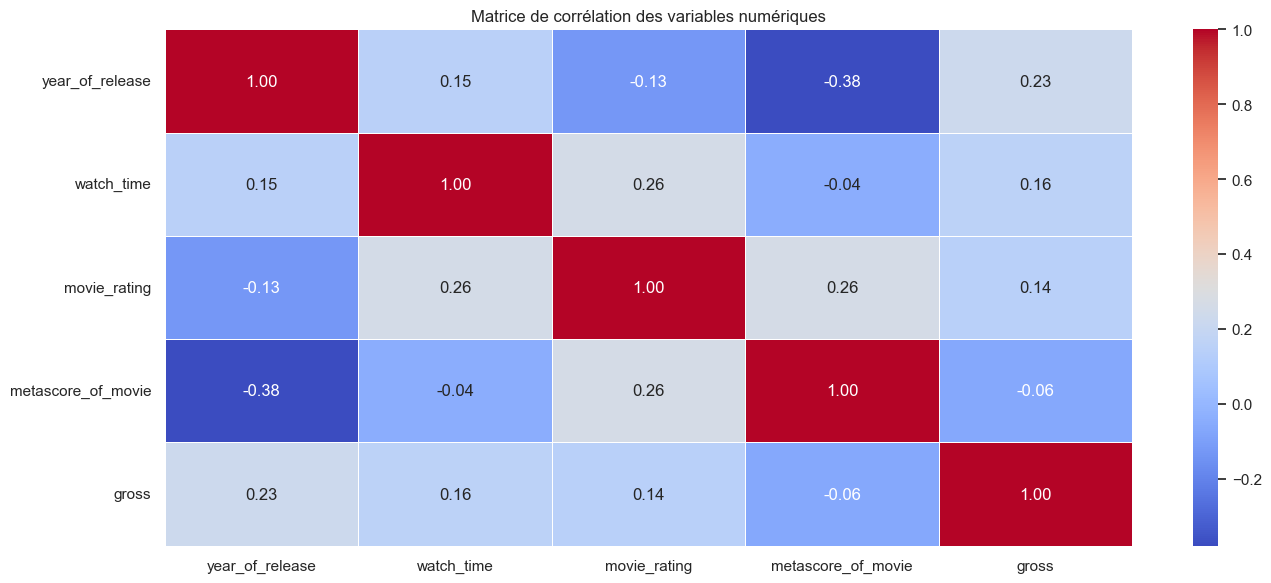

In [18]:

numerical_df = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numerical_df.corr()

# heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matrice de corr√©lation des variables num√©riques")
plt.tight_layout()
plt.show()

| Variables                                | Corr√©lation  | Interpr√©tation                                                                                  |
|-----------------------------------------:|-------------:|------------------------------------------------------------------------------------------------:|
| `movie_rating` & `metascore_of_movie`    | **0.26**     | Corr√©lation positive mod√©r√©e : les films bien not√©s par le public plaisent aussi √† la critique. |
| `watch_time` & `movie_rating`            | **0.26**     | Les films plus longs ont tendance √† √™tre un peu mieux not√©s.                                    |
| `year_of_release` & `metascore_of_movie` | **-0.38**    | Les films r√©cents ont tendance √† avoir un Metascore plus bas.                                   |
| `year_of_release` & `gross`              | **0.23**     | Les films r√©cents g√©n√®rent un peu plus de revenus en moyenne.                                   |
| `gross` & `movie_rating`                 | **0.14**     | Tr√®s faible lien : un bon film ne fait pas forc√©ment un gros box-office.                        |
| `watch_time` & `metascore_of_movie`      | **-0.04**    | Corr√©lation n√©gligeable entre dur√©e et avis critique.                                           |
| `gross` & `metascore_of_movie`           | **-0.06**    | Aucun lien significatif entre critiques presse et revenus.                                      |


**Conclusion**

L‚Äôanalyse exploratoire men√©e sur ce dataset de 1000 films a permis de d√©gager plusieurs tendances int√©ressantes autour des notes, dur√©es, revenus, et √©poques de sortie :

**Notes globalement √©lev√©es et concentr√©es**
- La majorit√© des films sont not√©s entre 7.5 et 8.5, avec une m√©diane autour de 8.0.
- Peu de films avec des notes extr√™mes, ce qui indique un niveau globalement √©lev√© de la s√©lection.

**Corr√©lations faibles mais r√©v√©latrices**
- La note publique (movie_rating) est l√©g√®rement corr√©l√©e au Metascore des critiques (ùúå ‚âà 0.26).
- Les revenus (gross) ne sont pas fortement li√©s √† la note ni au Metascore ‚Üí un bon film n‚Äôest pas forc√©ment un succ√®s commercial.
- Une dur√©e plus longue est associ√©e √† une note un peu plus √©lev√©e.

**√âvolution dans le temps**
- Le nombre de films sortis augmente fortement √† partir des ann√©es 90, avec un pic entre 2005 et 2015.
- Cependant, les notes ne suivent pas cette croissance ‚Üí la quantit√© ne rime pas toujours avec qualit√©.
- Les Metascores semblent en l√©g√®re baisse sur les p√©riodes les plus r√©centes.

**R√©partition par dur√©e**:
- Les films d‚Äôune dur√©e standard (90‚Äì150 min) dominent largement le dataset.
- Les films entre 150‚Äì180 min tendent √† obtenir les meilleures √©valuations.


L‚Äôunivers des films explor√©s ici montre une pr√©dominance de films bien not√©s, mais sans lien fort avec leur succ√®s commercial. La quantit√© de productions a explos√©, surtout apr√®s 2000, mais la qualit√© per√ßue reste stable. Les films plus longs obtiennent en moyenne de meilleures critiques, et les films plus anciens ont parfois des notes tr√®s √©lev√©es, soulignant peut-√™tre leur caract√®re culte ou leur impact historique.